Library


In [19]:
import math
import joblib
import numpy as np
import scipy.signal
import scipy.fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

Konstanta


In [20]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Random Seed


In [21]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Pra-Pemrosesan


In [22]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [23]:
def get_rms(segment):
    return np.sqrt(np.mean(segment ** 2))

def get_zcr(segment):
    return np.sum(np.abs(np.diff(np.signbit(segment)))) / (len(segment) / SAMPLE_RATE)

def get_lms(segment):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)
    return np.mean(mel_spec)

# Fuzzy Functions


Variabel


In [24]:
RMS_LOW_C = 0.021385268838932454
RMS_LOW_S = 170.58823145759033
RMS_MEDIUM_M = 0.046375479902471636
RMS_MEDIUM_S = 0.00501027974247247
RMS_HIGH_C = 0.2753180384748499
RMS_HIGH_S = 12.002275095623094
ZCR_INFREQ_C = 2493.1656190114886
ZCR_INFREQ_S = 0.0008620631418804517
ZCR_MODERATE_M = 4782.852668951398
ZCR_MODERATE_S = 4757.887314646938
ZCR_FREQ_C = 14748.051615194798
ZCR_FREQ_S = 0.004670963030780051
LOUD_C = 0.9335071916290064
LOUD_S = 42.770147326791694
NOT_LOUD_C = 0.1901805921119046
NOT_LOUD_S = 11.826406346881223

Membership Functions


In [25]:
def sigmf(x, c, s):
    return 1 / (1 + math.exp(-s * (x - c)))

def gaussmf(x, m, s):
    return math.exp(-((x - m) ** 2) / (2 * s ** 2))

Fuzzy Sets


In [26]:
def fuzzify_rms(val):
    return {
        'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
        'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
        'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
    }

def fuzzify_zcr(val):
    return {
        'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
        'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
        'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
    }

## Fuzzy Inference System


### Mamdani Inference Engine


In [27]:
def mamdani_rule_evaluation(rms_set, zcr_set):
    return [
        ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
        ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
        ('loud', min(rms_set['medium'], zcr_set['frequent'])),
        ('loud', min(rms_set['high'], zcr_set['infrequent'])),
        ('loud', min(rms_set['high'], zcr_set['moderate'])),
        ('loud', min(rms_set['high'], zcr_set['frequent']))
    ]

def mamdani_aggregate(rules):
    loud_dom = [s for l, s in rules if l == 'loud']
    not_loud_dom = [s for l, s in rules if l == 'not_loud']
    return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

def mamdani_defuzzify(loud, not_loud):
    output_range = np.linspace(0, 1, 101)
    numerator = 0
    denominator = 0
    for o in output_range:
        mu = max(
            min(sigmf(o, LOUD_C, LOUD_S), loud),
            min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
        )
        numerator += o * mu
        denominator += mu
    return numerator / denominator if denominator != 0 else 0

def fuzzy_mamdani_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = mamdani_rule_evaluation(rms_set, zcr_set)
    loud, not_loud = mamdani_aggregate(rules)
    return mamdani_defuzzify(loud, not_loud)

### Sugeno Inference Engine


In [28]:
def sugeno_rule_evaluation(rms_set, zcr_set):
    return [
        (min(rms_set['low'], zcr_set['infrequent']), 0.0),
        (min(rms_set['low'], zcr_set['moderate']), 0.0),
        (min(rms_set['low'], zcr_set['frequent']), 0.0),
        (min(rms_set['medium'], zcr_set['infrequent']), 0.0),
        (min(rms_set['medium'], zcr_set['moderate']), 0.0),
        (min(rms_set['medium'], zcr_set['frequent']), 1.0),
        (min(rms_set['high'], zcr_set['infrequent']), 1.0),
        (min(rms_set['high'], zcr_set['moderate']), 1.0),
        (min(rms_set['high'], zcr_set['frequent']), 1.0)
    ]

def sugeno_weighted_average(rules):
    numerator = sum(w * z for w, z in rules)
    denominator = sum(w for w, _ in rules)
    return numerator / denominator if denominator != 0 else 0

def fuzzy_sugeno_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = sugeno_rule_evaluation(rms_set, zcr_set)
    return sugeno_weighted_average(rules)

## Classification


In [29]:
def classify_output(output):
    return 1 if output >= 0.5 else 2

def classify_mamdani(rms_val, zcr_val):
    output = fuzzy_mamdani_infer(rms_val, zcr_val)
    return classify_output(output)

def classify_sugeno(rms_val, zcr_val):
    output = fuzzy_sugeno_infer(rms_val, zcr_val)
    return classify_output(output)

# Supervised Model


In [30]:
# # LGBM
# lgbm_path = r""
# model_lgbm = joblib.load(lgbm_path)

# # CNN
# cnn_path = r""
# model_cnn = joblib.load(cnn_path)

# # Conformer
# conformer_path = r""
# model_conformer = joblib.load(conformer_path)

# Visualization


In [31]:
def plot_audio_with_loud_segments(audio_path, list_result):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    
    time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title("Audio waveform with loud segments marked")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    for i, (out, _, _) in enumerate(list_result):
        if out == 1:
            start_time = i * (SEGMENT_DURATION / SAMPLE_RATE)
            end_time = start_time + (SEGMENT_DURATION / SAMPLE_RATE)
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
    
    plt.tight_layout()
    plt.legend()
    plt.show()

# Main


## Single Audio Inference


In [32]:
def single_inference(path, fis, sm):
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)
    
    list_result = []
    for segment in segments:
        rms = get_rms(segment)
        zcr = get_zcr(segment)
        
        if fis == "mamdani":
            out = classify_mamdani(rms, zcr)
        else:
            out = classify_sugeno(rms, zcr)
                
        # if out != 2:
        #     spec = get_lms(segment)
        #     if sm == "lgbm":
        #         out = model_lgbm(spec)
        #     else sm == "cnn":
        #         out = model_cnn(spec)
        #     else:
        #         out = model_conformer(spec)
        
        list_result.append((out, round(rms, 5), round(zcr, 5)))
    
    return list_result

# Execution


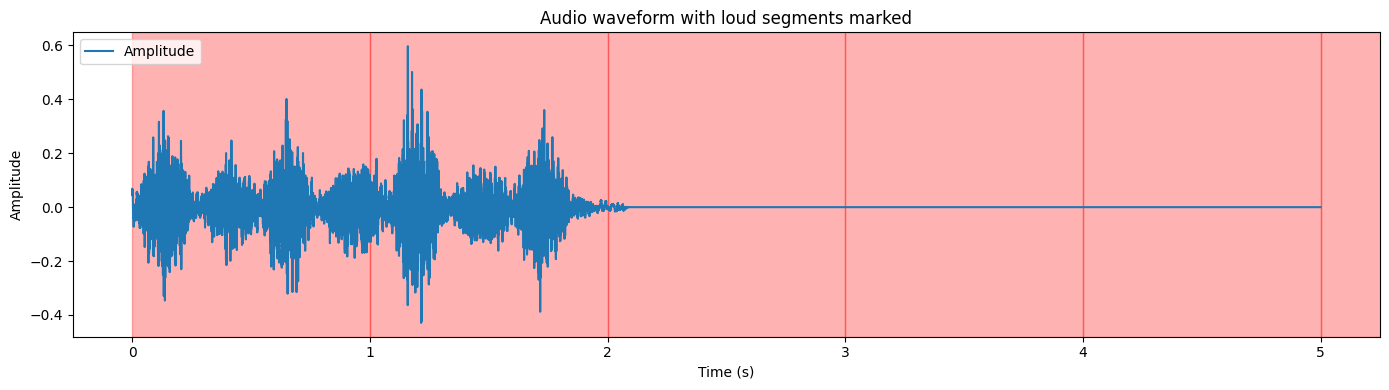

In [33]:
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\1-7974-B-49.wav"
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\498380.mp3"
option_fis = "mamdani"
option_sm = "cnn"

hasil_inferensi = single_inference(audio_path, option_fis, option_sm)
plot_audio_with_loud_segments(audio_path, hasil_inferensi)

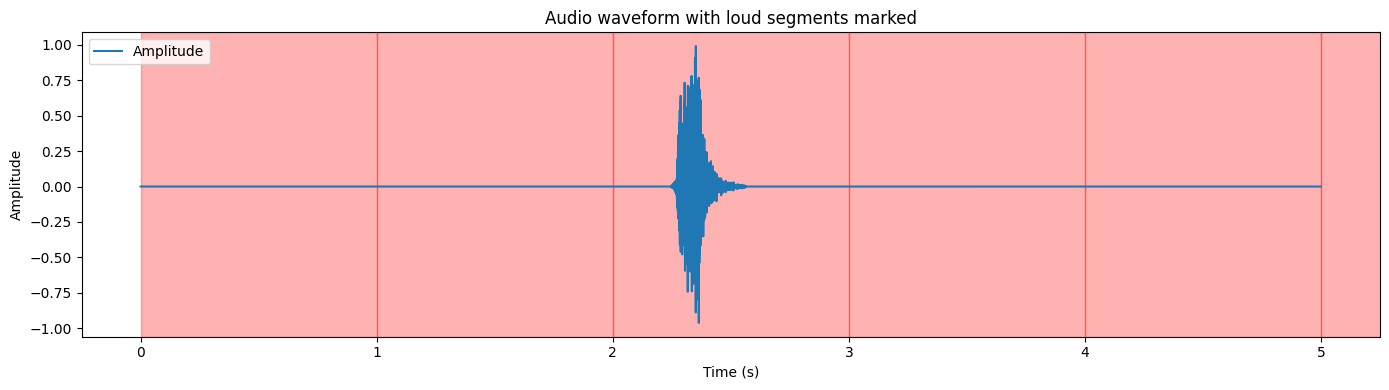

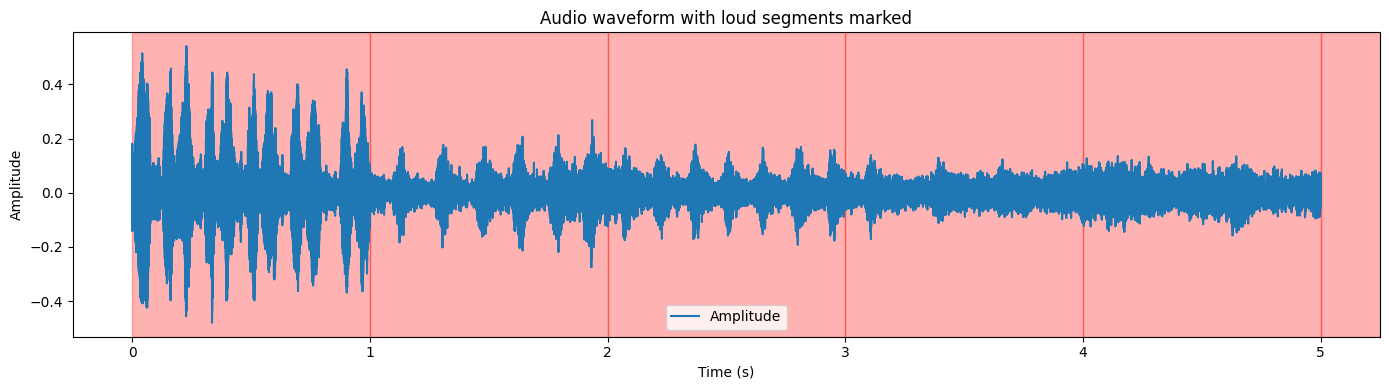

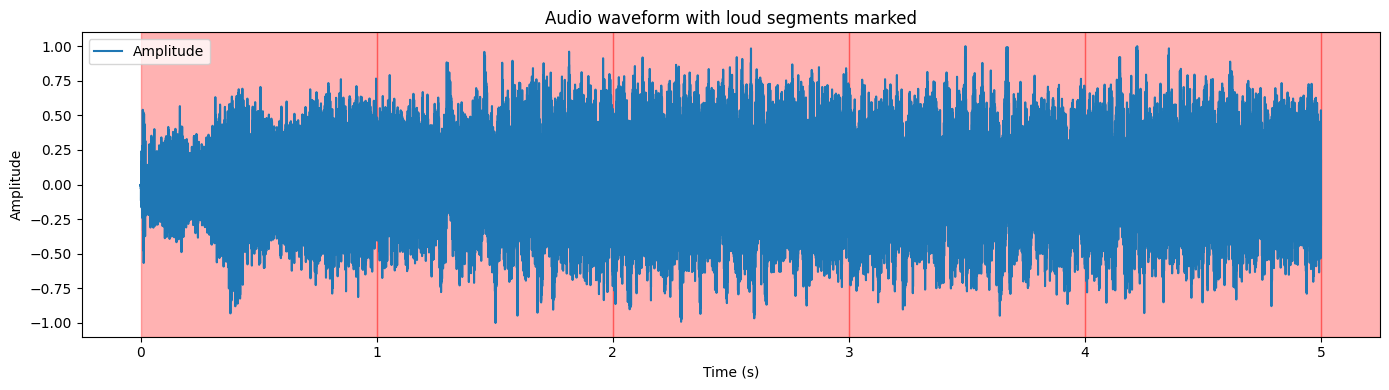

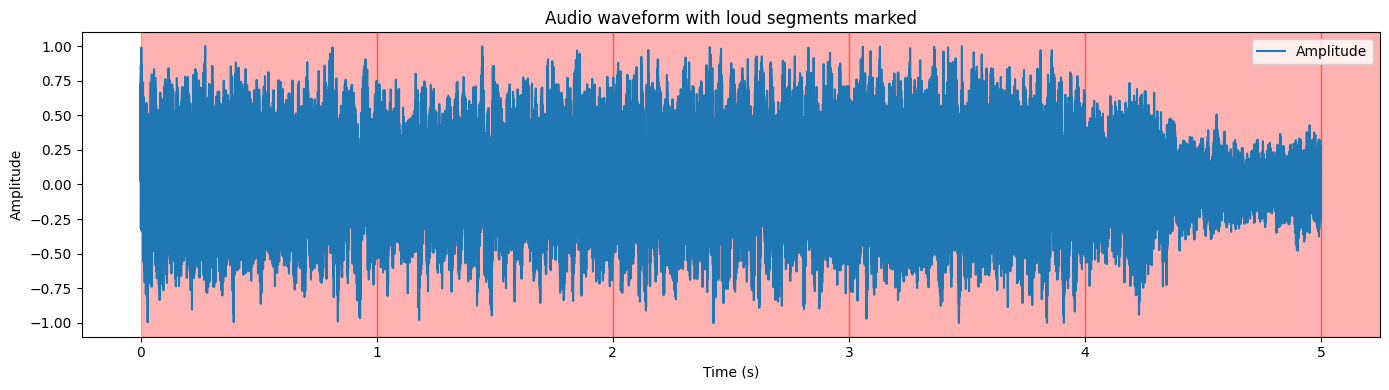

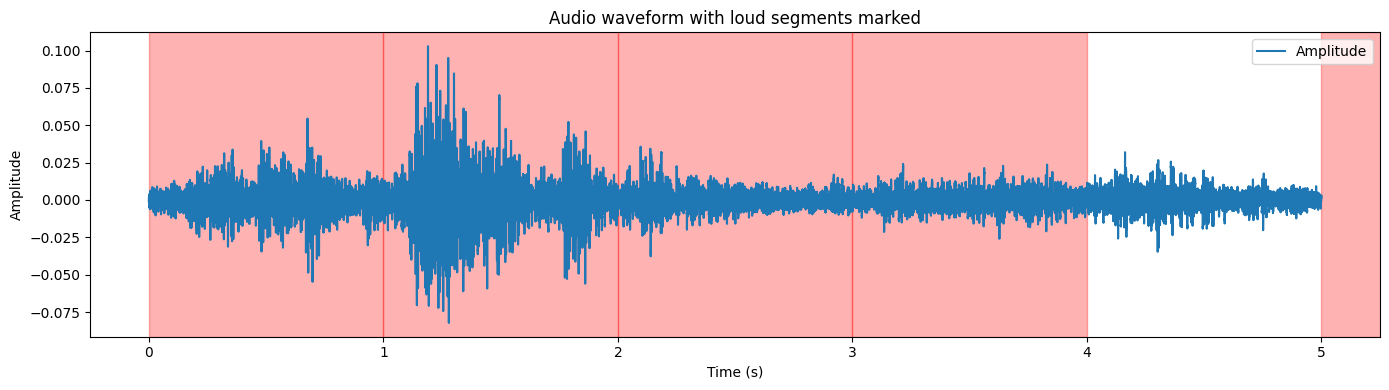

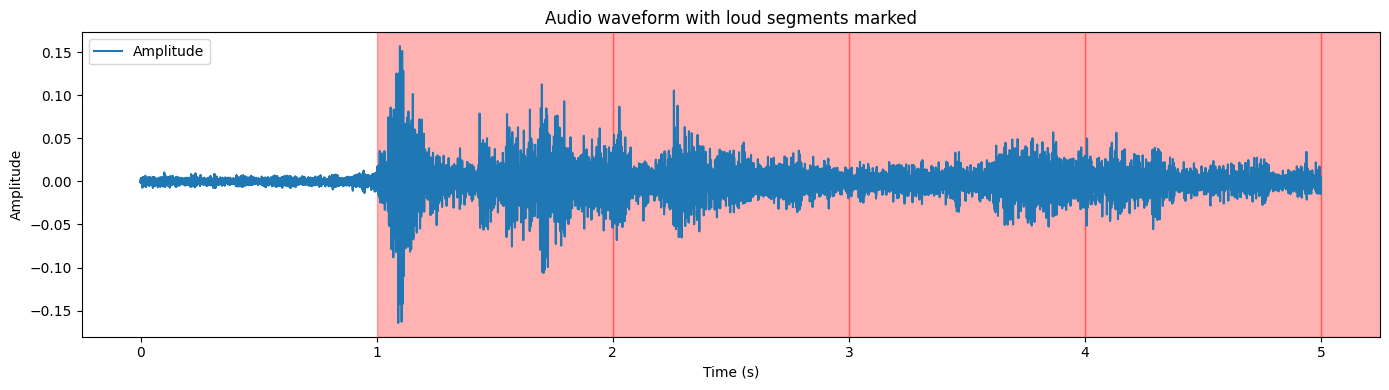

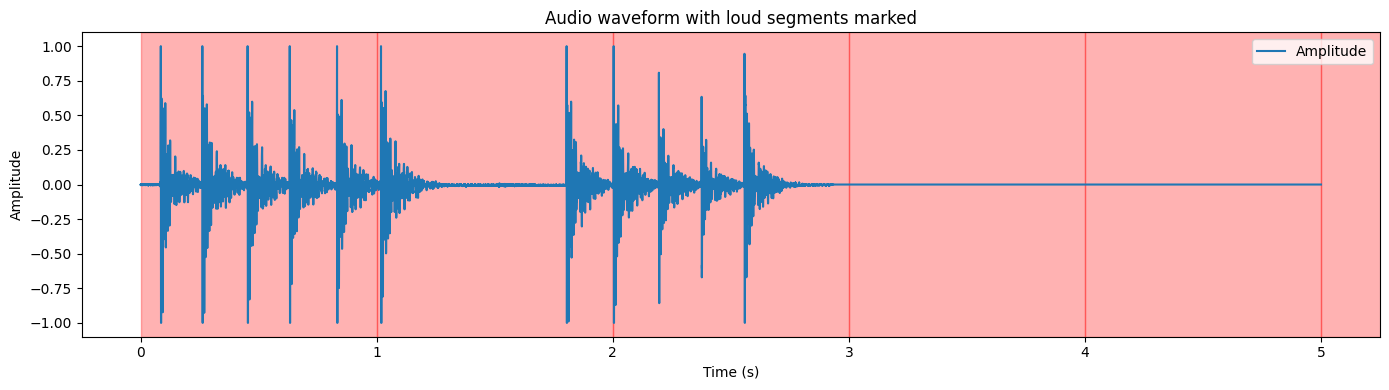

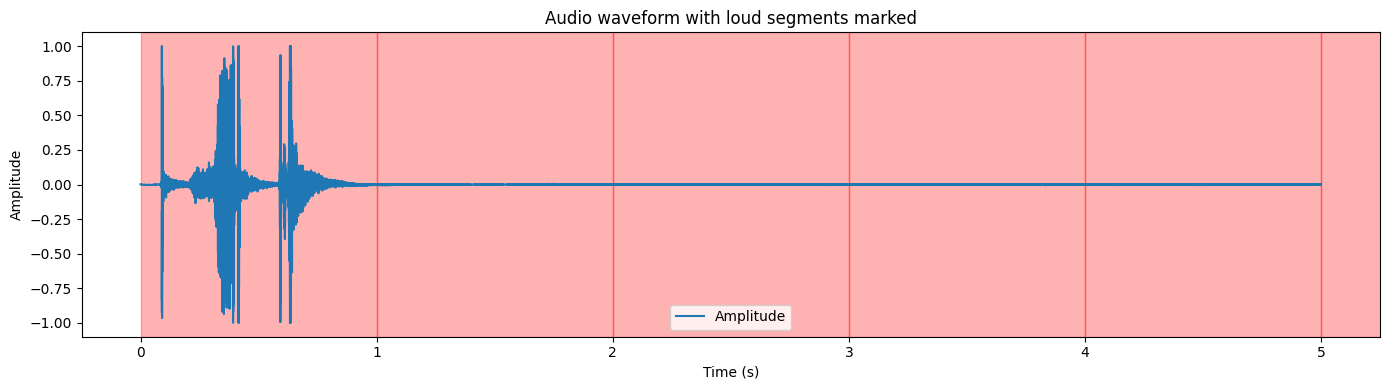

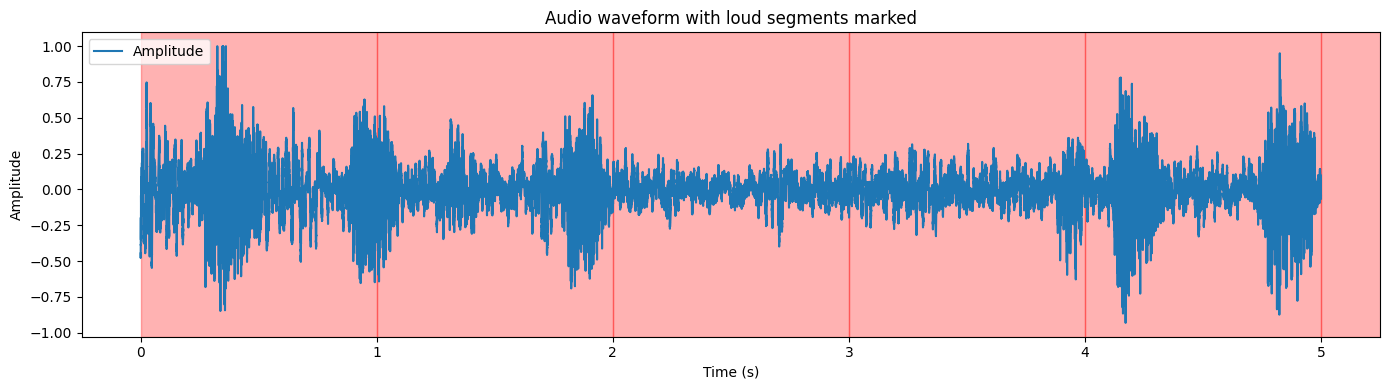

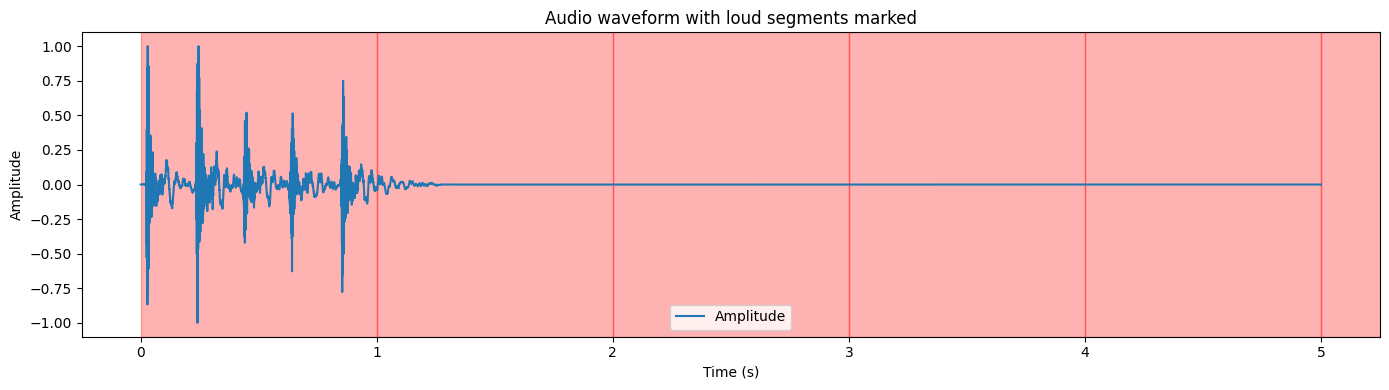

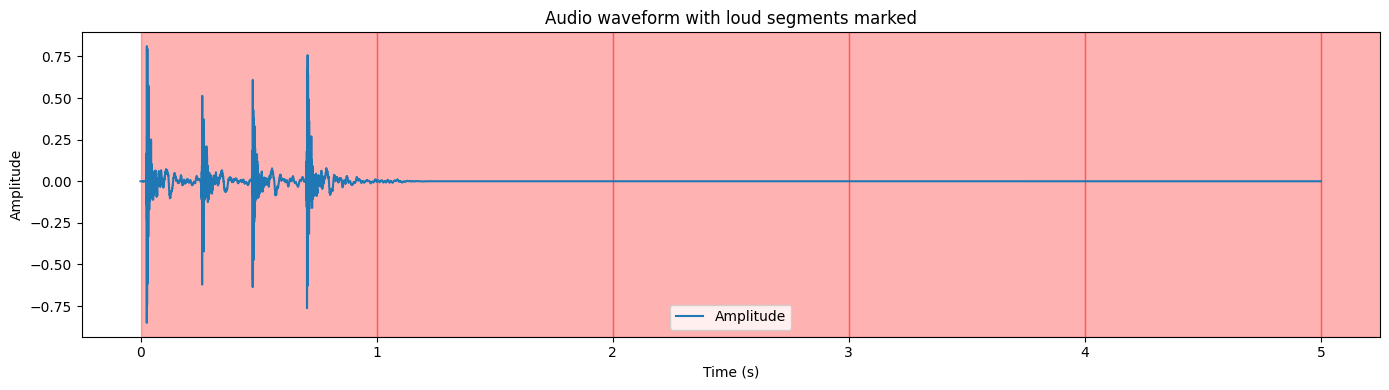

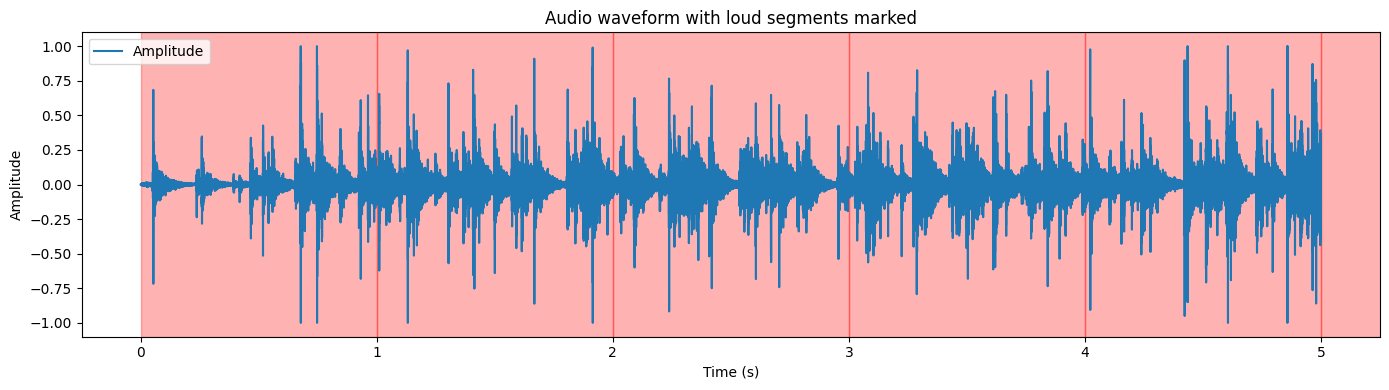

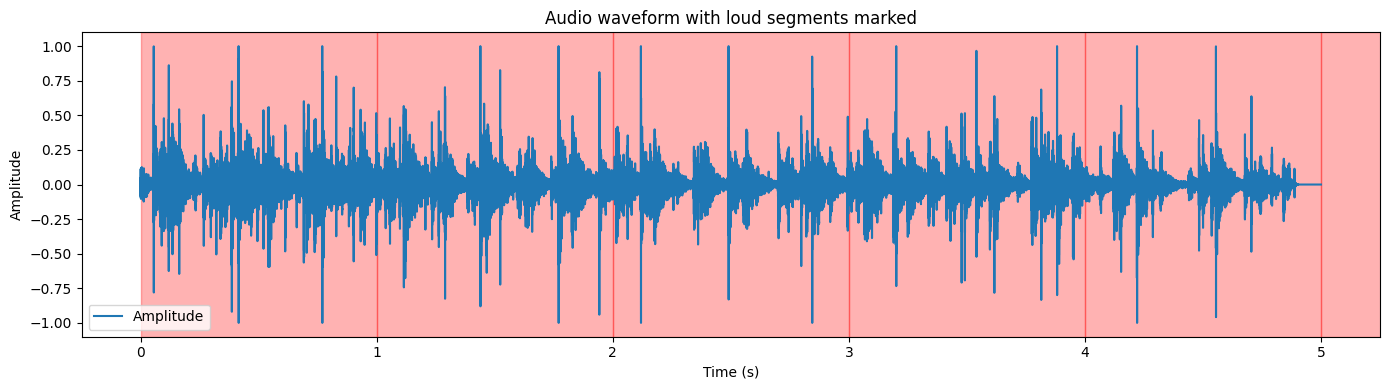

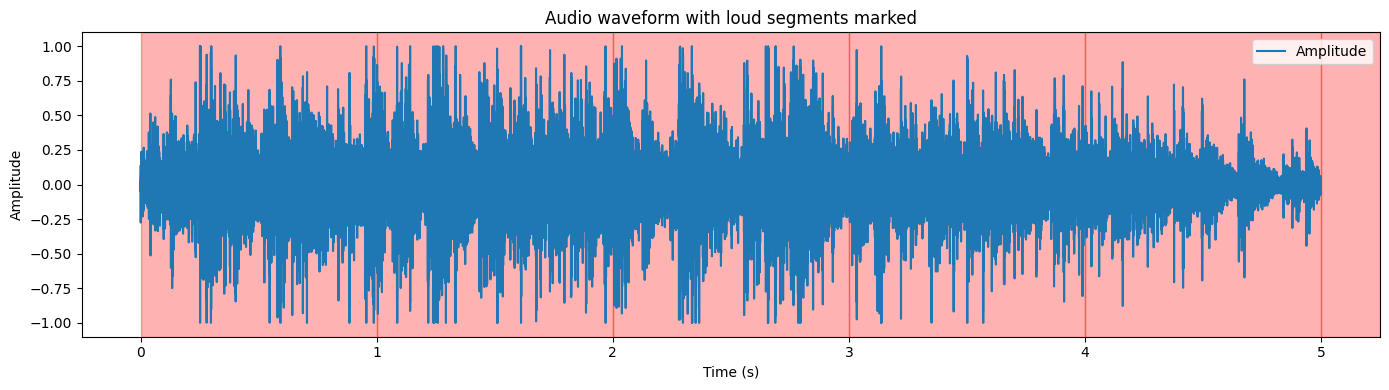

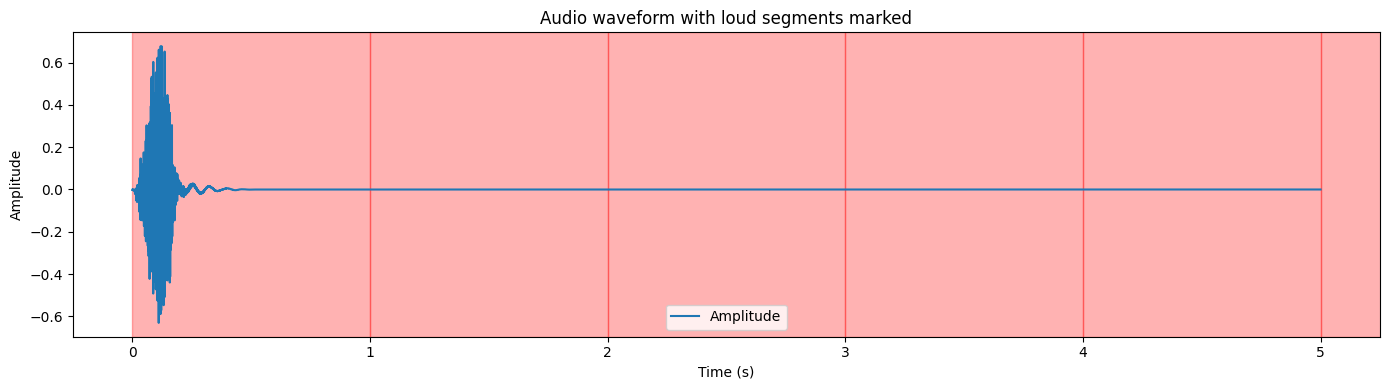

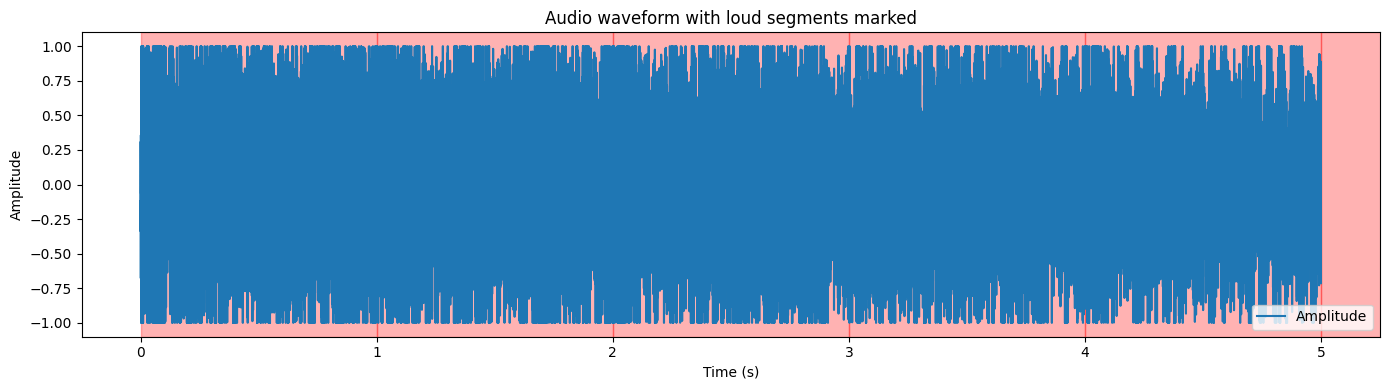

KeyboardInterrupt: 

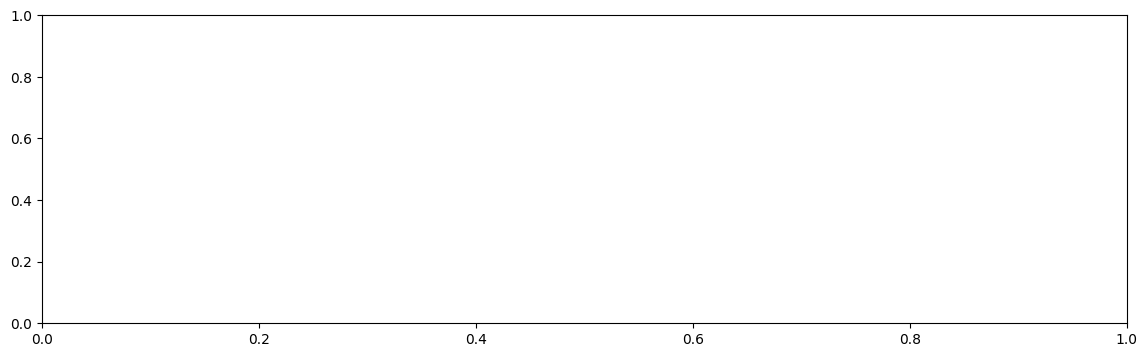

In [37]:
import os

audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data"
option_fis = "mamdani"
option_sm = "cnn"

for file in os.listdir(audio_path):
    hasil_inferensi = single_inference(f"{audio_path}/{file}", option_fis, option_sm)
    plot_audio_with_loud_segments(f"{audio_path}/{file}", hasil_inferensi)